# Домашнее задание #2
## Выполнили студенты 154 группы
### Алиев М.А. Потехин С.А. Кугушева А.С.

## Unsupervised

In [1]:
import re
import numpy as np
import warnings
import multiprocessing
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from time import time
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
from tqdm import tqdm
from plotly import tools

notebook_start = time()
# multiprocessing.set_start_method('forkserver')
warnings.filterwarnings('ignore')

XML файл обработан с помощью регулярных выражений, задача сведена к бинарной путем скрещивания классов 0 и 1.

In [2]:
def parse_xml(name):
    with open(name, 'r') as f:
        content = f.read()
    phrases = re.findall('(?<="text_[1,2]">)(.*)(?=</value>)', content)
    classes = re.findall('(?<="class">)(.*)(?=</value>)', content)
    def to_binary(elem):
        if elem == '-1': return 0
        if elem == '0':return 1
        return 1
    classes = [to_binary(i) for i in classes]
    return (phrases, classes)

# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [3]:
phrases, classes = parse_xml('paraphrases.xml')

В качестве препроцессинга текста была проведена лемматизация всех слов с помощью инструмента Mystem от яндекса. Далее лемматизированный текст был токенизирован и избавлен от набора стопcлов, взятого из пакета NLTK.

In [4]:
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# we need to lemmatize and tokenize text before
# teaching W2V model with them
m = Mystem()
tokenizer = TfidfVectorizer().build_tokenizer()
tokenized_corpus = []

def lemmatize_text(text, tok=True):
    lemmatized = ''.join(m.lemmatize(text))
    tokens = [i for i in tokenizer(lemmatized) if i not in stopwords.words('russian')]
    if not tok:
        tokens = ' '.join(tokens)
    return tokens

for i in phrases:
    tokenized_corpus.append(lemmatize_text(i))
    
pairs = list(chunks(tokenized_corpus, 2))

Для обучения без учителя было решено использовать модель эмбеддингов *Word2vec* с размерностью 100.

In [5]:
from gensim.models import Word2Vec

# creating and teaching model
model_w2v = Word2Vec(tokenized_corpus, size=100, workers=4, iter=25, min_count=2)
# extracting words vectors from word2vec
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.vectors))

Для каждой пары размеченных парафраз посчитаем их Word Mover's Distance.

In [6]:
all_distances = []
for i in pairs:
    dist = model_w2v.wmdistance(i[0], i[1])
    if dist == float('inf'): dist = 10
    all_distances.append(dist)
    
all_distances = np.array(all_distances)

Теперь подберем порог WMD, который будет определять, явлются ли 2 предложения парафразами. Для этого разобъем выборку на обучающую и тестовую в соотношении 3 к 1 и на первой будем перебирать значения порога в интервале от 5го до 95го процентиля. Итоговым порогом возьмем тот, для которого f1-score будет максимальным.

100%|██████████| 5000/5000 [00:08<00:00, 555.68it/s]


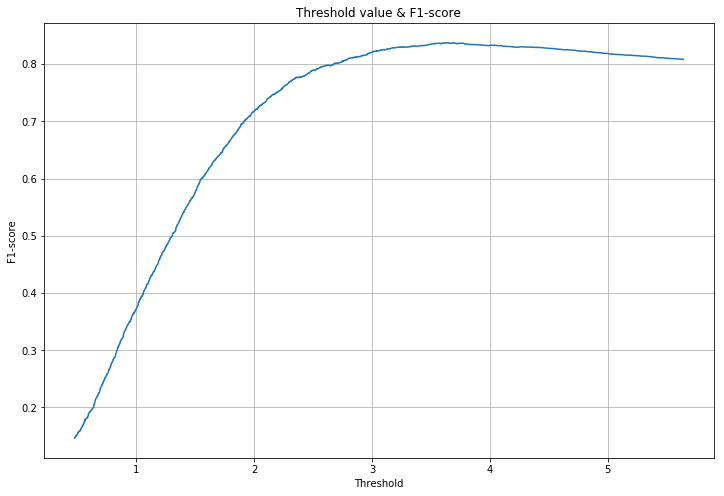

In [17]:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# kf = KFold(n_splits=10, shuffle=True)
X, y = all_distances, np.array(classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=224)


plt.figure(figsize=(12, 8))
best_thresholds = []
res_f1 = []
min_thr, max_thr = np.percentile(all_distances, [5, 95])
threshold_list = np.linspace(min_thr, max_thr, num=5000)
for thr in tqdm(threshold_list):
    y_pred = np.ones(len(X_train))
    y_pred[np.where(X_train > thr)[0]] = 0
    res_f1.append(f1_score(y_pred, y_train))
best_threshold = threshold_list[np.argmax(res_f1)]
plt.plot(threshold_list, res_f1)
plt.grid()
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Threshold value & F1-score')
plt.show()

In [18]:
final_thr = best_threshold
y_pred = np.ones(len(X_test))
y_pred[np.where(X_test > best_threshold)[0]] = 0

print ('Accuracy score: {}'.format(accuracy_score(y_pred, y_test)))
print ('F-Score: {}'.format(f1_score(y_pred, y_test)))
print ('Macro-score: {}'.format(fbeta_score(y_pred, y_test, beta=2)))

Accuracy score: 0.7493082457111234
F-Score: 0.8275599543205177
Macro-score: 0.769721002690837


## Supervised

Для обучения с учителем кроме уже использованного усредненного Word2Vec возьмем модели эмбеддингов Doc2Vec, FastText, Glove, а также Word2Vec с Tf-Idf весами. На каждом из них обучим kNN, MLP, RandomForest, SVM, LogReg, GradientBoosting и сравним результаты с помощью метрик accuracy, f1-score, fbeta-score(macro).

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import FastText
from glove import Glove, Corpus

# we already have word2vec
# doc2vec
documents_train = [TaggedDocument(' '.join(text), [id_]) for id_, text in enumerate(tokenized_corpus)]
model_d2v = Doc2Vec(documents_train, vector_size=100, workers=4, epochs=25, min_count=2)

# fastText
model_ft = FastText(tokenized_corpus, size=100, workers=4, iter=25, min_count=2)
# extracting words vectors from fastText
ft = dict(zip(model_ft.wv.index2word, model_ft.wv.vectors))

# Glove
corpus = Corpus()
corpus.fit(tokenized_corpus, window=10)
glove = Glove(no_components=100, learning_rate=0.01)
glove.fit(corpus.matrix, epochs=25, no_threads=4)
glove.add_dictionary(corpus.dictionary)
# extracting words vectors
glv = dict(zip(list(glove.dictionary.keys()), glove.word_vectors[list(glove.dictionary.values())]))

In [6]:
from collections import defaultdict
# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
class MeanEmbeddingVectorizer(object):
    def __init__(self, word_dict):
        self.word_dict = word_dict
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 100

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word_dict[w] for w in words if w in self.word_dict] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
class D2VEmbeddingVectorizer(object):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.model.infer_vector(" ".join(words), epochs=5) for words in X])
    
# same as MeanEmbeddingVectorizer but adding weights using tf-idf
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word_dict):
        self.word_dict = word_dict
        self.word2weight = None
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 100

    def fit(self, X, y):
        if self.word2weight:
            return self
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word_dict[w] * self.word2weight[w]
                         for w in words if w in self.word_dict] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Некоторые модели, такие как деревья или градиентный бустинг, требуют подбора параметров/гиперпараметров, для оптимизации процесса обучения или для предотвращения переобучения. Для перебора вариантов используем RandomizedSearchCV и проверим случайные 30 вариаций из заготовленного сета настроек.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

forest_params = {
    'n_estimators' : np.linspace(100, 1000, 10, dtype=np.int64),
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_depth' : list(np.linspace(10, 110, num = 11, dtype=np.int64)) + [None],
    'bootstrap' : [True, False],
    'criterion' : ['gini', 'entropy']
}

svm_params = {
    'C' : np.logspace(-3, 4, num=10),
    'gamma' : list(np.logspace(-6, 1, num=10)) + ['auto'],
    'class_weight' : ['balanced', None]
}

boosting_params = {
    'n_estimators' : np.linspace(50, 300, 10, dtype=np.int64),
    'max_depth' : np.linspace(3, 11, 5, dtype=np.int64),
    'min_samples_split' : [2, 4, 6],
    'min_samples_leaf' : [1, 2, 4],
    'learning_rate' : np.logspace(-2, 0, num=10),
    'max_features' : np.linspace(5, 30, 6, dtype=np.int64)
}

vectorizers = [
        ('Word2vec embedding', MeanEmbeddingVectorizer(w2v)),
        ('Glove embedding', MeanEmbeddingVectorizer(glv)),
        ('FastText embedding', MeanEmbeddingVectorizer(ft)),
        ('Doc2vec embedding', D2VEmbeddingVectorizer(model_d2v)),
        ('Weighted-word2vec embedding', TfidfEmbeddingVectorizer(w2v))
    ]
search_iterations = 30
models = [
        ('MultiLayerPerceptron', MLPClassifier(solver='adam', max_iter=300)),
        ('LogisticRegression', LogisticRegression(solver='sag', n_jobs=-1)),
        ('kNN', KNeighborsClassifier(n_jobs=-1)),
        ('RandomForest', RandomizedSearchCV(RFC(n_jobs=-1), forest_params, n_iter=search_iterations)),
        ('SVM', RandomizedSearchCV(SVC(), svm_params, n_iter=search_iterations)),
        ('GradientBoosting', RandomizedSearchCV(GBC(), boosting_params, n_iter=search_iterations))
    ]

In [7]:
%%time
X_train, X_test, y_train, y_test = train_test_split(pairs, np.array(classes), test_size=0.25, random_state=224)

X_train_concat = [i[0] + i[1] for i in X_train]
X_test_concat = [i[0] + i[1] for i in X_test]

X_train_full, X_test_full = [], []
for i in X_train:
    X_train_full += [i[0], i[1]]
    
for i in X_test:
    X_test_full += [i[0], i[1]]
    
X_full = X_train_full + X_test_full

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 12 ms


In [13]:
%%time
accuracy, macro, f1 = [], [], []
for model in models:
    for vect in vectorizers:
        print ('Training {} on {}'.format(model[0], vect[0]))
        p = Pipeline([vect, model])
        p.fit(X_train_concat, y_train)
        res = p.predict(X_test_concat)
        accuracy.append(accuracy_score(res, y_test))
        macro.append(fbeta_score(res, y_test, average='macro', beta=2))
        f1.append(f1_score(res, y_test))

Training MultiLayerPerceptron on Word2vec embedding
Training MultiLayerPerceptron on Glove embedding
Training MultiLayerPerceptron on FastText embedding
Training MultiLayerPerceptron on Doc2vec embedding
Training MultiLayerPerceptron on Weighted-word2vec embedding
Training LogisticRegression on Word2vec embedding
Training LogisticRegression on Glove embedding
Training LogisticRegression on FastText embedding
Training LogisticRegression on Doc2vec embedding
Training LogisticRegression on Weighted-word2vec embedding
Training kNN on Word2vec embedding
Training kNN on Glove embedding
Training kNN on FastText embedding
Training kNN on Doc2vec embedding
Training kNN on Weighted-word2vec embedding
Training RandomForest on Word2vec embedding
Training RandomForest on Glove embedding
Training RandomForest on FastText embedding
Training RandomForest on Doc2vec embedding
Training RandomForest on Weighted-word2vec embedding
Training SVM on Word2vec embedding
Training SVM on Glove embedding
Training

Визуализируем данные. Для каждой модели эмбеддингов построим график с результатами всех методов и набора метрик на них.

In [21]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

embeddings = ('Word2Vec', 'Glove', 'FastText', 'Doc2Vec', 'WeightedWord2Vec')
models_names = ('MLP','LogReg','kNN','RndFrst','SVM','GrBst')

fig = tools.make_subplots(rows=3, cols=2, subplot_titles=embeddings)

ac_counter, f1_counter, fb_counter = 0, 0, 0
all_models = []
all_acc = defaultdict(lambda: [])
all_f1 = defaultdict(lambda: [])
all_fb = defaultdict(lambda: [])
for model in models:
    for vect in vectorizers:
        all_models.append(model[0])
        vect = vect[0].split()[0]
        all_acc[vect].append(accuracy[ac_counter])
        ac_counter += 1
        all_f1[vect].append(f1[f1_counter])
        f1_counter += 1
        all_fb[vect].append(macro[fb_counter])
        fb_counter += 1
        
show_ = False
for idx, key in enumerate(all_acc.keys()):
    if idx == 4: show_ = True
    tmp = go.Scatter(
        x=models_names,
        y=all_acc[key],
        name='Accuracy score',
        line=dict(
            color=('orange')
        ),
        showlegend=show_
    )
    tmp2 = go.Scatter(
        x=models_names,
        y=all_f1[key],
        name='F1-score',
        line=dict(
            color=('blue')
        ),
        showlegend=show_
    )
    tmp3 = go.Scatter(
        x=models_names,
        y=all_fb[key],
        name='Macro-score',
        line=dict(
            color=('red')
        ),
        showlegend=show_
    )
    if idx == 4: idx += 1
    fig.append_trace(tmp, int((idx+1)/3 + 1), (idx+1)%2 + 1)
    fig.append_trace(tmp2, int((idx+1)/3 + 1), (idx+1)%2 + 1)
    fig.append_trace(tmp3, int((idx+1)/3 + 1), (idx+1)%2 + 1)

fig['layout'].update(height=1000, width=1000, title='Embeddings & Scores')
py.iplot(fig, filename='Embeddings subplots')
# fig

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



[Ссылка, если график не прогружается](https://plot.ly/~30mb1/32)

In [16]:
# import pickle

# with open('acc.pickle', 'wb') as f:
#     pickle.dump(accuracy, f)
    
# with open('f1.pickle', 'wb') as f:
#     pickle.dump(f1, f)
    
# with open('f_ma.pickle', 'wb') as f:
#     pickle.dump(macro, f)

In [14]:
import pickle

accuracy, macro, f1 = [], [], []
with open('acc.pickle', 'rb') as f:
    accuracy = pickle.load(f)
    
with open('f1.pickle', 'rb') as f:
    f1 = pickle.load(f)
    
with open('f_ma.pickle', 'rb') as f:
    macro = pickle.load(f)

## Supervised II

Было реализовано несколько вариантов нейронных сетей: Siamese DAN (от предложенной реализации отличается тем, что в кач-ве функции активации была использована сигмоида) а также несколько более простых FNNs. Для реализации всех сетей был использован фреймворк Keras.

Одна из вариаций использует специальный слой Embedding, данные для которого нужно подготовить. Каждая пара предложений соединяется в одно и кодируется (для каждого слова уникальное число). Слой настраивается с помощью матрицы, создающейся на основе w2v модели.

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, SpatialDropout1D, Flatten, Embedding
from keras.layers import Convolution1D, GlobalMaxPool1D, Input, Add, Multiply, Average
from keras.optimizers import Adam
import tensorflow as tf

X_full_concat = X_train_concat + X_test_concat

max_length = max([len(i) for i in X_full_concat])

# preparing data for special Embedding layer
clear_texts = [' '.join(i) for i in X_full_concat]
t = Tokenizer()
t.fit_on_texts(clear_texts)
vocab_size = len(t.word_index) + 1

clear_texts_train = [' '.join(i) for i in X_train_concat]
clear_texts_test = [' '.join(i) for i in X_test_concat]

# integer encode the documents
encoded_docs_train = t.texts_to_sequences(clear_texts_train)
padded_texts_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')

encoded_docs_test = t.texts_to_sequences(clear_texts_test)
padded_texts_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Using TensorFlow backend.


In [9]:
from tensorflow.python.client import device_lib
from keras import backend as K

device_lib.list_local_devices()
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Подготавливаем данные - усредненный w2v вектор для каждого из предложений, которые пойдут на вход отдельным веткам нейросети.

In [10]:
%%time
# preparing data for siamese and standard fNN
v = MeanEmbeddingVectorizer(w2v)
# v.fit(X_train_full, y_train)
embedded_data = v.transform(X_train_concat)
embedded_data_test = v.transform(X_test_concat)

texts_1, texts_2 = v.transform([i[0] for i in X_train]), v.transform([i[1] for i in X_train])
texts_1_test, texts_2_test = v.transform([i[0] for i in X_test]), v.transform([i[1] for i in X_test])

CPU times: user 455 ms, sys: 3.99 ms, total: 459 ms
Wall time: 461 ms


### Siamese DAN

In [11]:
%%time
inp1 = Input(shape=(embedded_data.shape[1],))
inp2 = Input(shape=(embedded_data.shape[1],))

dense12 = Dense(2048, activation='relu')(inp1)
dense22 = Dense(2048, activation='relu')(inp2)

dp1 = Dropout(0.35)(dense12)
dp2 = Dropout(0.35)(dense22)

dense13 = Dense(2048, activation='relu')(dp1)
dense23 = Dense(2048, activation='relu')(dp2)

dp11 = Dropout(0.3)(dense13)
dp22 = Dropout(0.3)(dense23)

mrg = Average()([dp11, dp22])

dense3 = Dense(1024, activation='relu')(mrg)
dp33 = Dropout(0.3)(dense3)
dense4 = Dense(1024, activation='relu')(dp33)
dp44 = Dropout(0.3)(dense4)
res_dense = Dense(1, activation='sigmoid')(dp44)

model1 = Model(input=[inp1, inp2], output=res_dense)
adam = Adam(lr=0.0005)
model1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
# summarize the model
print(model1.summary())
# fit the model
history1 = model1.fit([texts_1, texts_2], y_train, epochs=200, batch_size=512, verbose=1)
# # evaluate
y_pred = model1.predict([texts_1_test, texts_2_test]).flatten().round()
print('Accuracy: %f' % (accuracy_score(y_test, y_pred)))
print('F1-score: %f' % (f1_score(y_test, y_pred)))
print('F2-macro: %f' % (fbeta_score(y_test, y_pred, beta=2, average='macro')))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         206848      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         206848      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

5420/5420 [==============================] - 2s 321us/step - loss: 0.2217 - acc: 0.9026
Epoch 46/200
5420/5420 [==============================] - 2s 319us/step - loss: 0.2130 - acc: 0.9076
Epoch 47/200
5420/5420 [==============================] - 2s 296us/step - loss: 0.2093 - acc: 0.9122
Epoch 48/200
5420/5420 [==============================] - 2s 294us/step - loss: 0.2123 - acc: 0.9090
Epoch 49/200
5420/5420 [==============================] - 2s 296us/step - loss: 0.2187 - acc: 0.9068
Epoch 50/200
5420/5420 [==============================] - 2s 320us/step - loss: 0.2009 - acc: 0.9161
Epoch 51/200
5420/5420 [==============================] - 2s 315us/step - loss: 0.1924 - acc: 0.9144
Epoch 52/200
5420/5420 [==============================] - 2s 316us/step - loss: 0.1925 - acc: 0.9183
Epoch 53/200
5420/5420 [==============================] - 2s 319us/step - loss: 0.1913 - acc: 0.9166
Epoch 54/200
5420/5420 [==============================] - 2s 314us/step - loss: 0.1890 - acc: 0.9183
Epo

Epoch 126/200
5420/5420 [==============================] - 2s 298us/step - loss: 0.0747 - acc: 0.9696
Epoch 127/200
5420/5420 [==============================] - 2s 312us/step - loss: 0.0759 - acc: 0.9697
Epoch 128/200
5420/5420 [==============================] - 2s 301us/step - loss: 0.0700 - acc: 0.9710
Epoch 129/200
5420/5420 [==============================] - 2s 299us/step - loss: 0.0629 - acc: 0.9753
Epoch 130/200
5420/5420 [==============================] - 2s 325us/step - loss: 0.0675 - acc: 0.9731
Epoch 131/200
5420/5420 [==============================] - 2s 363us/step - loss: 0.0660 - acc: 0.9740
Epoch 132/200
5420/5420 [==============================] - 2s 361us/step - loss: 0.0739 - acc: 0.9710
Epoch 133/200
5420/5420 [==============================] - 2s 376us/step - loss: 0.0742 - acc: 0.9734
Epoch 134/200
5420/5420 [==============================] - 2s 376us/step - loss: 0.0683 - acc: 0.9716
Epoch 135/200
5420/5420 [==============================] - 2s 344us/step - loss: 0

In [12]:
trace1 = go.Scatter(
        x=list(range(200)),
        y=history1.history['acc'],
        name='Accuracy'
    )

trace2 = go.Scatter(
        x=list(range(200)),
        y=history1.history['loss'],
        name='Loss'
    )

# Edit the layout
layout = dict(title = 'Training history visualization',
              xaxis = dict(title = 'Epoch')
              )

fig = dict(data=[trace1, trace2], layout=layout)

# fig['layout'].update(height=1000, width=1000, title='Embeddings & Scores')
py.iplot(fig, filename='Siamese training history')

[Ссылка, если график не прогружается](https://plot.ly/~30mb1/34)

### FNN with embedding layer

In [13]:
%%time
model2 = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model2.add(e)
model2.add(Flatten())
model2.add(Dense(4096, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2048, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
# compile the model
adam = Adam(lr=0.0005)
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
# summarize the model
print(model2.summary())
# fit the model
history2 = model2.fit(padded_texts_train, y_train, epochs=50, batch_size=512, verbose=1)
# evaluate the model
y_pred = model2.predict_classes(padded_texts_test).flatten()
print('Accuracy: %f' % (accuracy_score(y_test, y_pred)))
print('F1-score: %f' % (f1_score(y_test, y_pred)))
print('F2-macro: %f' % (fbeta_score(y_test, y_pred, beta=2, average='macro')))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 100)           982600    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              9424896   
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
__________

In [14]:
trace1 = go.Scatter(
        x=list(range(100)),
        y=history2.history['acc'],
        name='Accuracy'
    )

trace2 = go.Scatter(
        x=list(range(100)),
        y=history2.history['loss'],
        name='Loss'
    )

# Edit the layout
layout = dict(title = 'Training history visualization',
              xaxis = dict(title = 'Epoch')
              )

fig = dict(data=[trace1, trace2], layout=layout)

py.iplot(fig, filename='Embedding-layred training history')

[Ссылка, если график не прогружается](https://plot.ly/~30mb1/38)

### Simple FNN

In [13]:
%%time

model3 = Sequential()
model3.add(Dense(4096, input_dim=embedded_data.shape[1], activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(2048, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid'))
# compile the model
adam = Adam(lr=0.0005)
model3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
# summarize the model
print(model3.summary())
# fit the model
history3 = model3.fit(embedded_data, y_train, epochs=150, batch_size=512, verbose=1)
# evaluate the model
y_pred = model3.predict_classes(embedded_data_test).flatten()
print('Accuracy: %f' % (accuracy_score(y_test, y_pred)))
print('F1-score: %f' % (f1_score(y_test, y_pred)))
print('F2-macro: %f' % (fbeta_score(y_test, y_pred, beta=2, average='macro')))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4096)              413696    
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1025      
Total para

5420/5420 [==============================] - 1s 260us/step - loss: 0.1051 - acc: 0.9596
Epoch 150/150
5420/5420 [==============================] - 2s 296us/step - loss: 0.0997 - acc: 0.9590
Accuracy: 0.689579
F1-score: 0.764349
F2-macro: 0.651228
CPU times: user 2min 15s, sys: 49.4 s, total: 3min 4s
Wall time: 3min 47s


In [14]:
trace1 = go.Scatter(
        x=list(range(150)),
        y=history3.history['acc'],
        name='Accuracy'
    )

trace2 = go.Scatter(
        x=list(range(150)),
        y=history3.history['loss'],
        name='Loss'
    )

# Edit the layout
layout = dict(title = 'Training history visualization',
              xaxis = dict(title = 'Epoch')
              )

fig = dict(data=[trace1, trace2], layout=layout)

py.iplot(fig, filename='Simple FNN')

[Ссылка, если график не прогружается](https://plot.ly/~30mb1/40)

Сиамская нейросеть дала наилучшие результаты, однако ее время обучения было наибольшим из-за большого количества слоев. Далее с практически идентичными результатами шли простые нейросети, однако та, что использовала Embedding слой обучалась в разы быстрее (99% accuracy на тренировочный выборке при 50 эпохах против 96% на 150 эпохах).